In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error as rmse
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
data = pd.read_csv("../data/raw/Clean_Dataset.csv")
data.head()
data.drop(columns="Unnamed: 0", axis=1, inplace=True)

print(data.info())
print(data.describe())
print(data["class"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB
None
            duration      days_left          price
count  300153.000000  300153.000000  300153.000000
mean       12.221021      26.004751   20889.660523
std         7.191997      13.561004   22697.

In [10]:
data = data.drop(["flight"], axis = 1)
print(data.columns)

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'duration', 'days_left', 'price'],
      dtype='object')


In [11]:
data['stops_num'] = data['stops'].replace({
    'one': 1,
    'zero': 1,
    'two_or_more': 2,  # if exists
})

df_numeric = data.select_dtypes(include=['int64','float64'])
print(df_numeric.shape)

C:\Users\User\AppData\Local\Temp\ipykernel_21088\3798545113.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['stops_num'] = data['stops'].replace({


(300153, 4)


In [20]:
X = data.drop(["price", "stops"], axis = 1)
y = data["price"]
print(X.shape, y.shape)

(300153, 9) (300153,)


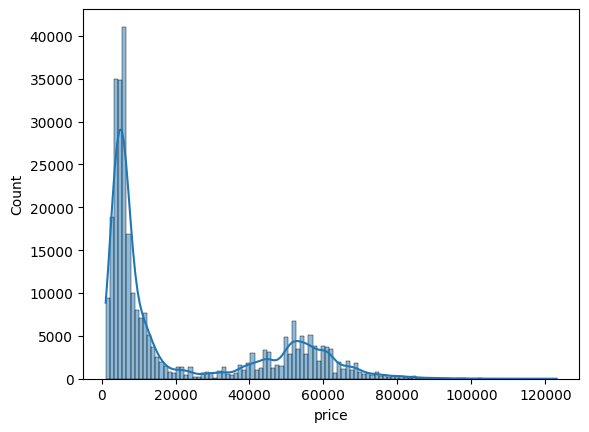

In [21]:
sns.histplot(data=df_numeric, x="price", kde=True)
plt.show()

In [22]:
categorical = (X.select_dtypes(include = ["object"]).drop("class", axis = 1)).columns.tolist()
col_class = ["class"]
numerical = df_numeric.drop("price", axis=1).columns.tolist()
print(categorical, numerical)

['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city'] ['duration', 'days_left', 'stops_num']


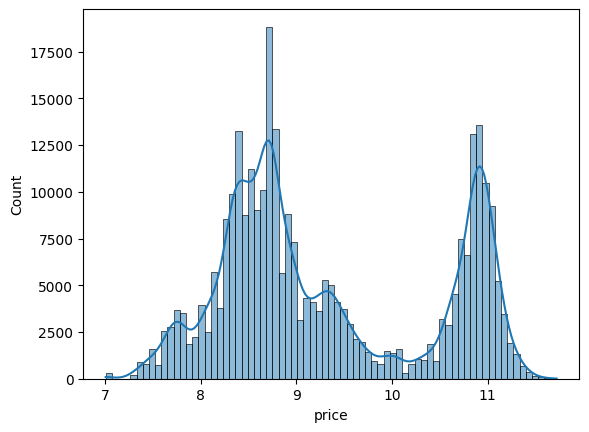

In [23]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)

y_log = log_transformer.transform(y)

sns.histplot(data = y_log, kde=True)
plt.show()


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("class", OrdinalEncoder(categories=[['Economy', 'Business']]), col_class),
        ("num", "passthrough", numerical),
    ]
)

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

y_train_log = log_transformer.transform(y_train)
y_test_log  = log_transformer.transform(y_test)

print(X_train_trans.shape, X_test_trans.shape)


(240122, 34) (60031, 34)


In [32]:
print(X_train.columns.tolist())

['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'stops_num']


In [93]:
rfr = RandomForestRegressor( max_depth = 20)
rfr.fit(X_train_trans, y_train_log)

RandomForestRegressor(max_depth=20)

In [94]:
r2 = r2_score(y_test, log_transformer.inverse_transform(rfr.predict(X_test_trans)))
print(f"The model achieved r2 score: {r2}")



The model achieved r2 score: 0.9845321410407522


In [95]:
rmse = rmse(y_test, log_transformer.inverse_transform(rfr.predict(X_test_trans)))
print(f"The model achieved rmse: {rmse}")


The model achieved rmse: 2823.7222072214804


133.84254681774215 <bound method Series.std of 27131      168.236746
266857   -4375.103472
141228      -2.112614
288329     429.177851
97334      367.702583
             ...     
5234       -84.952091
5591       171.470535
168314     610.182533
175191    1350.743677
287693   -5679.571515
Name: price, Length: 60031, dtype: float64>


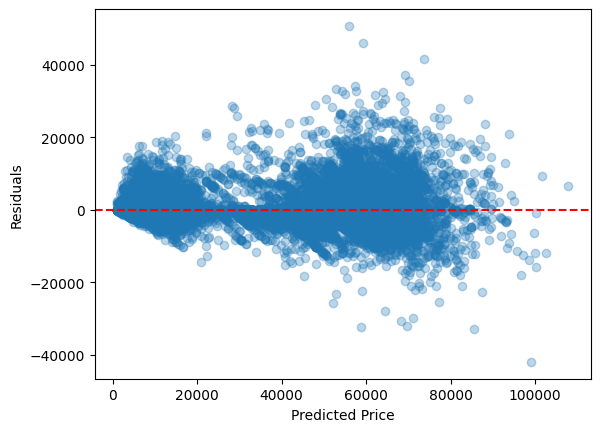

In [98]:
import matplotlib.pyplot as plt

y_pred = log_transformer.inverse_transform(rfr.predict(X_test_trans))
residuals = y_test - y_pred
print(residuals.mean(), residuals.std)

plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.show()

In [47]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline

# Define the model
lgb_reg = lgb.LGBMRegressor(
    n_estimators=2000,      # set a high number
    learning_rate=0.05,
    max_depth=-1,
    random_state=1111
)

# Add early stopping via callbacks
callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True)]

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb_reg)
])

# Fit with eval_set
pipeline.fit(
    X_train_trans, y_train_log,
    model__eval_set=[(X_test_trans, y_test_log)],
    model__eval_metric="rmse",
    model__callbacks=callbacks
)


ValueError: Specifying the columns using strings is only supported for dataframes.

In [44]:
rmse_lgb = rmse(y_test, log_transformer.inverse_transform(lgb_reg.predict(X_test_trans)))
print(f"The model achieved rmse: {rmse_lgb}")





/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


The model achieved rmse: 3399.0126526543263


In [45]:
r2_lgb = r2_score(y_test, log_transformer.inverse_transform(lgb_reg.predict(X_test_trans)))
print(f"The model achieved r2 score: {r2_lgb}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


The model achieved r2 score: 0.9775874213231106


In [48]:
import joblib

# Save preprocessing object
joblib.dump(preprocessor, "preprocessor.pkl")

# Save trained model
joblib.dump(lgb_reg, "lgb_model.pkl")

['lgb_model.pkl']